# Анализ данных интернет-магазина

### Заказчик передал данные интернет-магазина, состоящие из трех таблиц:

#### olist_customers_datase.csv — таблица с уникальными идентификаторами пользователей

customer_id — позаказный идентификатор пользователя

customer_unique_id —  уникальный идентификатор пользователя  (аналог номера паспорта)

customer_zip_code_prefix —  почтовый индекс пользователя

customer_city —  город доставки пользователя

customer_state —  штат доставки пользователя

#### olist_orders_dataset.csv —  таблица заказов

order_id —  уникальный идентификатор заказа (номер чека)

customer_id —  позаказный идентификатор пользователя

order_status —  статус заказа

order_purchase_timestamp —  время создания заказа

order_approved_at —  время подтверждения оплаты заказа

order_delivered_carrier_date —  время передачи заказа в логистическую службу

order_delivered_customer_date —  время доставки заказа

order_estimated_delivery_date —  обещанная дата доставки

#### olist_order_items_dataset.csv —  товарные позиции, входящие в заказы

order_id —  уникальный идентификатор заказа (номер чека)

order_item_id —  идентификатор товара внутри одного заказа

product_id —  ид товара (аналог штрихкода)

seller_id — ид производителя товара

shipping_limit_date —  максимальная дата доставки продавцом для передачи заказа партнеру по логистике

price —  цена за единицу товара

freight_value —  вес товара

#### Уникальные статусы заказов в таблице olist_orders_dataset:

- created —  создан
- approved —  подтверждён
- invoiced —  выставлен счёт
- processing —  в процессе сборки заказа
- shipped —  отгружен со склада
- delivered —  доставлен пользователю
- unavailable —  недоступен
- canceled —  отменён

### Задача - проанализировать данные, и дать комментарии бизнесу о состоянии дел в маркетплейсе.

In [1]:
# импорт необходимых библиотек
import requests
from io import BytesIO
import pandas as pd
import numpy as np
from datetime import timedelta
from datetime import datetime
from io import StringIO
from urllib.parse import urlencode
import copy
import seaborn as sns
import matplotlib.pyplot as plt

### Выгрузка данных с Яндекс.Диска

Для начала выгрузим данные с диска. Для этого напишем функцию, которая принимает на вход ссылку для скачивания данных, скачивает таблицы и записывает их в датасеты:

In [2]:
def get_data(link):
    base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
    final_url = base_url + urlencode(dict(public_key=link))
    response = requests.get(final_url)
    download_url = response.json().get('href')
    download_response = requests.get(download_url)
    return download_response.content  

In [3]:
# выгружаем таблицу с пользователями с применением написанной ранее функции
link = 'https://disk.yandex.ru/d/QXrVDUoQvFhIcg'
file_content = get_data(link)  
customers = pd.read_csv(StringIO(file_content.decode('utf-8')))  

In [4]:
# выгружаем таблицу с заказами с применением написанной ранее функции
link = 'https://disk.yandex.ru/d/0zWmh1bYP6REbw'
file_content = get_data(link)  
orders = pd.read_csv(StringIO(file_content.decode('utf-8')), parse_dates=[
            'order_delivered_carrier_date',
            'order_delivered_customer_date',
            'order_estimated_delivery_date',
            'order_purchase_timestamp',
            'order_approved_at'
        ]) 

In [5]:
# выгружаем таблицу с товарами с применением написанной ранее функции
link = 'https://disk.yandex.ru/d/xCsQ0FiC-Ue4Lg'
file_content = get_data(link)  
items = pd.read_csv(StringIO(file_content.decode('utf-8')), parse_dates=['shipping_limit_date']) 

### Разведочный анализ

Теперь, когда данные скачаны, нужно провести проверочный анализ для каждой из таблиц, чтобы понимать контекст, и нужна ли предобработка данных

#### Таблица с покупателями

In [6]:
# посмотрим на типы данных в таблице с покупателями
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   customer_id               99441 non-null  object
 1   customer_unique_id        99441 non-null  object
 2   customer_zip_code_prefix  99441 non-null  int64 
 3   customer_city             99441 non-null  object
 4   customer_state            99441 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.8+ MB


In [7]:
customers.describe(include='object')

,customer_id,customer_unique_id,customer_city,customer_state
count,99441,99441,99441,99441
unique,99441,96096,4119,27
top,5a0dc6805a195218a4e448653dee4740,8d50f5eadf50201ccdcedfb9e2ac8455,sao paulo,SP
freq,1,17,15540,41746


In [8]:
customers.groupby(['customer_state', 'customer_city'], as_index = False)['customer_id'].count().sort_values('customer_id', ascending = False)

,customer_state,customer_city,customer_id
4176,SP,sao paulo,15540
2788,RJ,rio de janeiro,6882
1062,MG,belo horizonte,2773
601,DF,brasilia,2131
2406,PR,curitiba,1521
...,...,...,...
3037,RS,cerro grande,1
3036,RS,cerrito,1
3033,RS,caseiros,1
1316,MG,ipuiuna,1


У нас собраны данные о пользователях из 27 штатов Бразилии. Больше всего пользователей - из Сан-Паулу. 

In [9]:
customers.isna().sum()

customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64

Всего в таблице собраны данные о данные 99441 пользователях (при этом если считать по уникальным id (поле customer_unique_id - аналог номера паспорта) - их 96096). Пропуски в таблице - отсутсвуют.

#### Таблица с заказами

In [10]:
# посмотрим на типы данных в таблице с заказами
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_id                       99441 non-null  object        
 1   customer_id                    99441 non-null  object        
 2   order_status                   99441 non-null  object        
 3   order_purchase_timestamp       99441 non-null  datetime64[ns]
 4   order_approved_at              99281 non-null  datetime64[ns]
 5   order_delivered_carrier_date   97658 non-null  datetime64[ns]
 6   order_delivered_customer_date  96476 non-null  datetime64[ns]
 7   order_estimated_delivery_date  99441 non-null  datetime64[ns]
dtypes: datetime64[ns](5), object(3)
memory usage: 6.1+ MB


In [11]:
orders.describe(include='object')

,order_id,customer_id,order_status
count,99441,99441,99441
unique,99441,99441,8
top,44437f0cd12aae191555f66ce8dc2d5f,5a0dc6805a195218a4e448653dee4740,delivered
freq,1,1,96478


In [12]:
orders.describe(include='datetime64')

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  """Entry point for launching an IPython kernel.
/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  """Entry point for launching an IPython kernel.
/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence thi

,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
count,99441,99281,97658,96476,99441
unique,98875,90733,81018,95664,459
top,2018-03-31 15:08:21,2018-02-27 04:31:10,2018-05-09 15:48:00,2018-05-14 20:02:44,2017-12-20 00:00:00
freq,3,9,47,3,522
first,2016-09-04 21:15:19,2016-09-15 12:16:38,2016-10-08 10:34:01,2016-10-11 13:46:32,2016-09-30 00:00:00
last,2018-10-17 17:30:18,2018-09-03 17:40:06,2018-09-11 19:48:28,2018-10-17 13:22:46,2018-11-12 00:00:00


In [13]:
orders.isna().sum()

order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

In [14]:
orders_copy = copy.deepcopy(orders)
orders_copy['order_purchase_timestamp'] = orders_copy['order_purchase_timestamp'].dt.to_period('M')

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24]),
 <a list of 25 Text major ticklabel objects>)

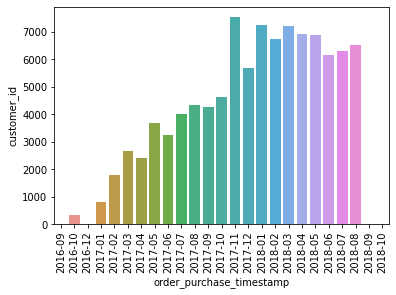

In [15]:
orders_by_month = orders_copy.groupby('order_purchase_timestamp', as_index = False).agg({'customer_id':'count'})
sns.barplot(x='order_purchase_timestamp', y='customer_id', data=orders_by_month)
plt.rcParams['figure.figsize'] = (12, 8)
plt.xticks(rotation=90)

Первый заказ был сделан 4 сентября 2016 года, последний - 17 октября 2018 года. Т.е. данные в таблице представлены за 2 года. 
Самый частый статус заказа 'доставлен' (уже хорошо).

В таблице достаточно много пропусков:

- 160 заказов не подтверждены;
- 1783 заказа не имеют даты передачи заказа в логистическую службу;
- 2965 не имеют времени доставки заказа.

Таким образом можно отметить, что имеется ряд трудностей с доставкой товаров, на что стоило бы обратить внимание.
В целом, количество пользователей интернет магазина растет с течением времени.

#### Таблица с товарами

In [16]:
# посмотрим на типы данных в таблице с товарами
items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   order_id             112650 non-null  object        
 1   order_item_id        112650 non-null  int64         
 2   product_id           112650 non-null  object        
 3   seller_id            112650 non-null  object        
 4   shipping_limit_date  112650 non-null  datetime64[ns]
 5   price                112650 non-null  float64       
 6   freight_value        112650 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(3)
memory usage: 6.0+ MB


In [17]:
items.describe(include='float64')

,price,freight_value
count,112650.000000,112650.000000
mean,120.653739,19.990320
std,183.633928,15.806405
min,0.850000,0.000000
25%,39.900000,13.080000
50%,74.990000,16.260000
75%,134.900000,21.150000
max,6735.000000,409.680000


In [18]:
items.isna().sum()

order_id               0
order_item_id          0
product_id             0
seller_id              0
shipping_limit_date    0
price                  0
freight_value          0
dtype: int64

Судя по разбросу цен товаров - товары в ассортименте магазина относятся к различным категориям. Пропуски в таблице отсутсвуют.

### Решение задач

Теперь, когда у нас есть представление о данных, с которыми предстоит работать, можно приступать к ответам на поставленные вопросы.

Прежде всего сформулируем что именно мы будем считать 'покупкой' в рамках решения данного кейса:

Согласно описанию данных, заказы имеют следующие статусы доставки:
- created —  создан
- approved —  подтверждён
- invoiced —  выставлен счёт
- processing —  в процессе сборки заказа
- shipped —  отгружен со склада
- delivered —  доставлен пользователю
- unavailable —  недоступен
- canceled —  отменён

В рамках данной задачи, здесь и далее 'покупкой' будут считаться заказы со статусом 'delivered' и имеющие дату подтверждения в колонке 'order_approved_at'. 

Данное решение принято по аналогии с работой популярных маркетплейсов в России: со статусами unavailable и canceled - все понятно, они точно не идут в расчет. Однако, все остальные заказы, со статусами не равными delivered, могут быть не забраны из ПВЗ по инициативе покупателя/возвращены по каким либо причинам покупателем и будут отправлены обратно на склад, а денежные средства вернутся покупателю. Соответсвенно считать такие заказы  'покупкой' наперед мы не можем.
И, соответсвенно, чтобы избежать ошибок системы все доставленные заказы должны быть подтверждены со стороны продавца.

#### Сколько у нас пользователей, которые совершили покупку только один раз?

In [19]:
# объединим таблицы с данными о покупателях и заказах и создадим копию датафрейма чтобы работать с ней в рамках этой задачи
cust_n_order_data = customers.merge(orders, how = 'inner', on = 'customer_id') 
cust_n_order_data_1 = copy.deepcopy(cust_n_order_data)

In [20]:
# отберем те строки, которые соответсвуют нашему критерию 'покупки', и посчитаем кол-во заказов для каждого уникального пользователя
orders_by_customer = cust_n_order_data_1.query("order_status == 'delivered' and order_approved_at != 'NaN'") \
                     .groupby('customer_unique_id', as_index = False).agg({'order_id':'count'}) \
                     .rename(columns={'order_id':'numb_of_orders'}) \
                     .sort_values('numb_of_orders', ascending = False)

In [21]:
orders_by_customer.head()

,customer_unique_id,numb_of_orders
51426,8d50f5eadf50201ccdcedfb9e2ac8455,15
22779,3e43e6105506432c953e165fb2acf44c,9
36705,6469f99c1f9dfae7733b25662e7f1782,7
73911,ca77025e7201e3b30c44b472ff346268,7
10060,1b6c7548a2a1f9037c1fd3ddfed95f33,7


In [22]:
orders_by_customer.shape[0]

93345

In [23]:
# подсчитаем кол-во пользователей с одной покупкой
customers_with_ohe_order = orders_by_customer.query('numb_of_orders == 1').numb_of_orders.count()

In [24]:
persent = (customers_with_ohe_order * 100 / orders_by_customer.shape[0]).round(1)

In [25]:
print(f'Количество пользователей, совершивших покупку один раз - {customers_with_ohe_order} человек или {persent}% от общего числа пользователей')

Количество пользователей, совершивших покупку один раз - 90545 человек или 97.0% от общего числа пользователей


Исходя из полученных данных, можно сделать вывод, что покупатели крайне редко повторно заказывают в данном интернет магазине. Для бизнеса это не благоприятная ситуация

#### Сколько заказов в месяц в среднем не доставляется по разным причинам (вывести детализацию по причинам)

In [26]:
# создадим копию датафрейма чтобы работать с ней в рамках этой задачи
orders_copy = copy.deepcopy(orders)

In [27]:
# создадим столбец с месяцем и годом заказа
orders_copy['month_of_order'] = orders_copy['order_estimated_delivery_date'].dt.to_period('M')

In [28]:
#отсеем доставленные заказы
#посчитаем кол-во заказов с разным статусом для каждого месяца
#переименуем колонку с кол-вом заказов
#посчитаем среднее кол-во заказов с разным статусом в месяц
#отсортируем значения
not_delivered_orders_by_month = orders_copy.query("order_status != 'delivered'")\
.groupby(['month_of_order', 'order_status'], as_index = False).agg({'order_id':'count'})\
.rename(columns = {'order_id':'num_of_orders'})\
.groupby('order_status', as_index = False).agg({'num_of_orders':'mean'})\
.sort_values(by='num_of_orders',ascending=False).round(2)

In [29]:
not_delivered_orders_by_month

,order_status,num_of_orders
5,shipped,48.13
6,unavailable,29.00
1,canceled,24.04
4,processing,15.84
3,invoiced,14.95
2,created,1.67
0,approved,1.00


На данном этапе анализа подтверждаются предположения, что в магазине есть проблема с доставкой товаров. Около 40% заказов в месяц имеют статус недоступен  или отменен. Даже если предположить что все остальные заказы с другими статусами пройдут весь цикл успешно и станут покупками, 40% - это много.

#### По каждому товару определить, в какой день недели товар чаще всего покупается

In [30]:
# объединим таблицы с данными о заказах товарах и создадим копию датафрейма чтобы работать с ней в рамках этой задачи
order_n_item_data = orders.merge(items, how = 'inner', on = 'order_id') 
order_n_item_data_1 = copy.deepcopy(order_n_item_data)

In [31]:
# создаем столбец с названием дней недели
order_n_item_data_1['day_of_week'] = order_n_item_data_1['order_purchase_timestamp'].dt.day_name()

In [32]:
# отберем те строки, которые соответсвуют нашему критерию 'покупки'
# для каждого товара посчитаем кол-во покупок по дням недели
#переименуем колонку с кол-вом заказов
#отсортируем значения
item_orders_by_day = order_n_item_data_1.query("order_status == 'delivered' and order_approved_at != 'NaN'")\
.groupby(['product_id', 'day_of_week'], as_index = False).agg({'order_status':'count'})\
.rename(columns={'order_status':'num_of_orders'})\
.sort_values(['product_id','num_of_orders'], ascending = False) 

In [33]:
#для каждого товара отберем стоки с максимальным кол-вом заказов
days_with_max_sells_for_items = item_orders_by_day.loc[item_orders_by_day.groupby('product_id')['num_of_orders'].idxmax()].sort_values('num_of_orders')

In [34]:
days_with_max_sells_for_items

,product_id,day_of_week,num_of_orders
0,00066f42aeeb9f3007548bb9d3f33c38,Sunday,1
36704,9d6c4148e617e319b543737dfe71cc5f,Thursday,1
36703,9d6bf1b7a541b5205e4fd5aa40282f33,Monday,1
36702,9d6a788ceee3a2c4ef57a459d5a202eb,Wednesday,1
36701,9d6a5df183306316cd9954e052f30dd3,Friday,1
...,...,...,...
12742,368c6c730842d78016ad823897a372db,Friday,67
19707,53b36df67ebb7c41585e8d54d6772e08,Tuesday,76
40177,aca2eb7d00ea1a7b8ebd4e68314663af,Thursday,89
35745,99a4788cb24856965c36a24e339b6058,Monday,91


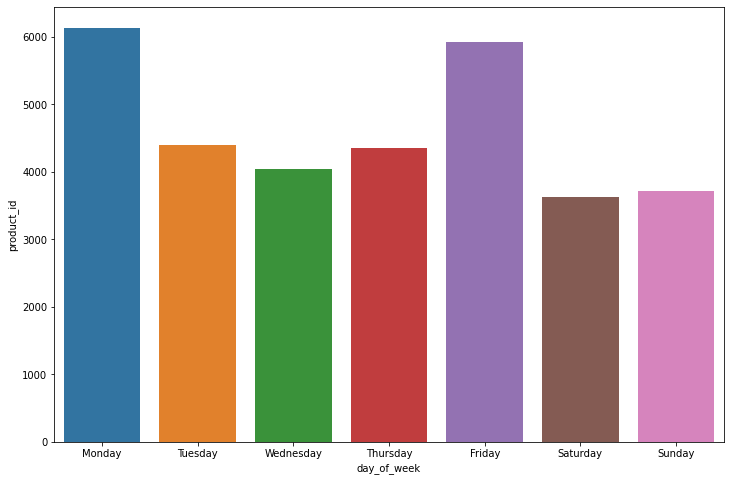

In [35]:
for_vizualization = days_with_max_sells_for_items.groupby('day_of_week', as_index =False).agg({'product_id':'count'})

day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
for_vizualization['day_of_week'] = pd.Categorical(for_vizualization['day_of_week'], categories=day_order, ordered=True)

sns.barplot(x='day_of_week', y='product_id', data=for_vizualization)

Итак, для большей части товаров, днями с максимальным количеством заказов с большим количественным отрывом являются понедельник и пятница. На втором месте - вторник и четверг. В суббота и воскресенье являются наиболее популярными для заказов для наименьшей части товаров. В целом, така ситуация хорошо коррелирует с графиком работы большей части населения: в понедельник люди делают покупки на предстоящую рабочую неделю, в пятницу закупаются к выходным, в субботу и воскресенье большая часть людей отдыхают и им не нужен большой ассортимент товаров.

#### Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)

In [36]:
# объединим таблицы с данными о покупателях и заказах и создадим копию датафрейма чтобы работать с ней в рамках этой задачи
cust_n_order_data = customers.merge(orders, how = 'inner', on = 'customer_id') 
cust_n_order_data_2 = copy.deepcopy(cust_n_order_data)

In [37]:
#из столбца с датой создания заказа извлекаем месяц и год заказа (чтобы потом посмотреть мин и макс дату наблюдений)
cust_n_order_data_2['date_of_order'] = cust_n_order_data_2['order_purchase_timestamp'].dt.date

In [38]:
# создадим столбец с месяцем и годом заказа
cust_n_order_data_2['month_of_order'] = cust_n_order_data_2['order_purchase_timestamp'].dt.to_period('M')

In [39]:
#создаем в таблице с заказами столбец с указанием количества дней в каждом месяце (используем дату создания заказа для изучения поведения пользователей)
cust_n_order_data_2['days_in_month'] = cust_n_order_data_2['order_purchase_timestamp'].dt.daysinmonth
#создаем столбец с количеством недель в месяце - для этого количество дней в месяц делим на 7 дней
cust_n_order_data_2['weeks_in_month'] = cust_n_order_data_2.days_in_month / 7

In [40]:
# следуя ранее установленной логике, оставим только то, что соответсвует нашему определению покупки:
cust_n_order_data_2 = cust_n_order_data_2.query("order_status == 'delivered' and order_approved_at != 'NaN'")

In [41]:
min_data = cust_n_order_data_2.date_of_order.min()
max_data = cust_n_order_data_2.date_of_order.max()

print(f'Минимальная дата {min_data} \nМаксимальная дата {max_data}')

Минимальная дата 2016-09-15 
Максимальная дата 2018-08-29


Отфильтрованный датафрейм включает в себя наблюдения с 15 сентября 2016 по 29 августа 2018 года. Соответсвенно наблюдения за первый и последний месяцы охватывают не все дни и будут давать искажения при расчете. Поэтому исключим их.

In [42]:
cust_n_order_data_2['date_of_order'] = pd.to_datetime(cust_n_order_data_2['date_of_order'])
filtered = cust_n_order_data_2.query("date_of_order >= '2016-10-01 00:00:00' and date_of_order <= '2018-07-31 23:59:59'")

In [43]:
#для каждого уникального пользователя считаем общее количество заказов в месяц
orders_per_month_by_users = filtered.groupby(['customer_unique_id', 'month_of_order'], as_index = False).agg({'order_id':'count'})\
.rename(columns={'order_id':'num_of_orders'})\
.sort_values('num_of_orders')

In [44]:
orders_per_month_by_users

,customer_unique_id,month_of_order,num_of_orders
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05,1
59053,a9da5a115fdd7b13412153e54dc02604,2018-04,1
59052,a9d935a890e7b3d7a15dc0ed603b1af9,2017-10,1
59051,a9d91b01596a92bb257b5b3a5490ef20,2018-01,1
59050,a9d7b1930b1726fae8b6bd573b7dcb11,2018-01,1
...,...,...,...
45874,83e7958a94bd7f74a9414d8782f87628,2017-01,4
21719,3e43e6105506432c953e165fb2acf44c,2018-02,4
61413,b08fab27d47a1eb6deda07bfd965ad43,2017-09,4
56380,a239b8e2fbce33780f1f1912e2ee5275,2017-02,4


In [45]:
#создаем более компактный датафрейм, в котором оставляем только необходимые для рассчетов колонки
weeks_in_month = filtered[['customer_unique_id', 'weeks_in_month']]

In [46]:
#объединяем таблицы с количеством заказов и количеством недель в месяц
result_table = orders_per_month_by_users.merge(weeks_in_month, how = 'left', on = 'customer_unique_id')

In [47]:
#добавляем в результирующую таблицу столбец с количеством заказов в неделю (делим заказы в месяц на кол-во недель в месяце)
result_table['order_per_week'] = result_table.num_of_orders / result_table.weeks_in_month

In [48]:
#а теперь для кажого уникального пользователя в разбивке по месяцам считаем среднее кол-во заказов в неделю
result_table = result_table.groupby(['customer_unique_id', 'month_of_order'], as_index = False ).agg({'order_per_week':'mean'}).sort_values('order_per_week')

In [49]:
result_table

,customer_unique_id,month_of_order,order_per_week
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05,0.225806
50980,93027a697145bb67a134f56e9a3f0d9a,2017-01,0.225806
50982,9304a65759d081e8c86846970b0e9848,2018-01,0.225806
50985,93073fef423711fb08efdb2d596d7404,2018-01,0.225806
50987,930958664b249ce7ea76b0a85db1b1d6,2018-05,0.225806
...,...,...,...
61413,b08fab27d47a1eb6deda07bfd965ad43,2017-09,0.933333
21719,3e43e6105506432c953e165fb2acf44c,2018-02,0.949582
62898,b4e4f24de1e8725b74e4a1f4975116ed,2018-02,0.980645
56380,a239b8e2fbce33780f1f1912e2ee5275,2017-02,1.000000


In [50]:
result_table.order_per_week.quantile([0.25, 0.5, 0.75])

0.25    0.225806
0.50    0.225806
0.75    0.233333
Name: order_per_week, dtype: float64

У большинства пользователей среднее количество покупок в неделю - 0.226. И только у 25% - 0.233

#### Выполнить когортный анализ в период с января по декабрь, с подсчетом Retention

In [51]:
# объединим таблицы с данными о покупателях и заказах и создадим копию датафрейма чтобы работать с ней в рамках этой задачи
cust_n_order_data = customers.merge(orders, how = 'inner', on = 'customer_id') 
cust_n_order_data_3 = copy.deepcopy(cust_n_order_data)

In [52]:
# следуя ранее установленной логике, оставим только то, что соответсвует нашему определению покупки:
cust_n_order_data_3 = cust_n_order_data_3.query("order_status == 'delivered' and order_approved_at != 'NaN'")

In [53]:
# приведем столбец с датой заказа к формату месяцев
cust_n_order_data_3['order_purchase_timestamp'] = cust_n_order_data_3['order_purchase_timestamp'].dt.to_period('M')

In [54]:
#создаем колонку с данными о месяце первого заказа для каждого уникального пользователя.
cust_n_order_data_3['first_purchase'] = cust_n_order_data_3.groupby('customer_unique_id')['order_purchase_timestamp'].transform('min')

In [55]:
#сделаем группировку по месяцам заказов, чтобы понять, за какой год у нас имеются данные с января по декабрь
cust_n_order_data_3.groupby('order_purchase_timestamp').customer_unique_id.count()

order_purchase_timestamp
2016-09       1
2016-10     265
2016-12       1
2017-01     748
2017-02    1641
2017-03    2546
2017-04    2303
2017-05    3546
2017-06    3135
2017-07    3872
2017-08    4193
2017-09    4150
2017-10    4478
2017-11    7289
2017-12    5513
2018-01    7069
2018-02    6555
2018-03    7003
2018-04    6798
2018-05    6749
2018-06    6099
2018-07    6159
2018-08    6351
Freq: M, Name: customer_unique_id, dtype: int64

Полные данные за 12 месяцев есть только для 2017 года, поэтому далее когортный анализ будем проводить только за 2017 год

In [56]:
cust_n_order_data_3 = cust_n_order_data_3.query("'2017-01' <= first_purchase <= '2017-12'")

In [57]:
# сформируем когорты, для этого сгруппируем данные по дате первого заказа и просто дате заказов, для кадой посчитаем кол-во уникальных пользователей
cohort_table = cust_n_order_data_3.groupby(['first_purchase', 'order_purchase_timestamp'],as_index=False).agg({'customer_unique_id': 'nunique'})

In [58]:
# добавим столбец в котором будет разница в месяцах между датой первого и последующих заказов
cohort_table['dif'] = (cohort_table['order_purchase_timestamp'].dt.year - cohort_table['first_purchase'].dt.year) * 12 + (cohort_table['order_purchase_timestamp'].dt.month - cohort_table['first_purchase'].dt.month)

In [59]:
# трансформируем таблицу
cohort_table_pivot = cohort_table.pivot(index='first_purchase', columns = 'dif', values = 'customer_unique_id')

In [60]:
# рассчитаем retention как отношение числа пользователей за каждый последующий месяц использования с их числом в первый месяц
retention = cohort_table_pivot.div(cohort_table_pivot.iloc[:,0], axis = 0)

In [61]:
# зададим настройки отображения
table_style = (retention
            .style
            .set_caption('User retention by cohort')  # добавляем подпись
            .background_gradient(cmap='viridis')  # раскрашиваем ячейки по столбцам
            .highlight_null('white')  # делаем белый фон для значений NaN
            .format("{:.2%}", na_rep=""))  # числа форматируем как проценты, NaN заменяем на пустоту
table_style

dif,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,19
first_purchase,,,,,,,,,,,,,,,,,,,
2017-01,100.00%,0.28%,0.28%,0.14%,0.42%,0.14%,0.42%,0.14%,0.14%,,0.42%,0.14%,0.70%,0.42%,0.14%,0.14%,0.28%,0.42%,0.14%
2017-02,100.00%,0.19%,0.31%,0.12%,0.43%,0.12%,0.25%,0.19%,0.06%,0.19%,0.12%,0.31%,0.12%,0.19%,0.12%,0.06%,0.06%,0.19%,
2017-03,100.00%,0.44%,0.36%,0.40%,0.36%,0.16%,0.16%,0.32%,0.32%,0.08%,0.36%,0.12%,0.20%,0.12%,0.16%,0.24%,0.08%,0.12%,
2017-04,100.00%,0.62%,0.22%,0.18%,0.27%,0.27%,0.35%,0.31%,0.31%,0.18%,0.27%,0.09%,0.04%,0.04%,0.09%,0.09%,0.13%,,
2017-05,100.00%,0.46%,0.46%,0.29%,0.29%,0.32%,0.41%,0.14%,0.26%,0.26%,0.26%,0.35%,0.23%,0.03%,0.17%,0.20%,,,
2017-06,100.00%,0.49%,0.40%,0.43%,0.30%,0.40%,0.36%,0.23%,0.13%,0.20%,0.30%,0.36%,0.16%,0.16%,0.23%,,,,
2017-07,100.00%,0.53%,0.35%,0.24%,0.29%,0.21%,0.32%,0.11%,0.19%,0.27%,0.21%,0.29%,0.13%,0.24%,,,,,
2017-08,100.00%,0.69%,0.35%,0.27%,0.35%,0.52%,0.30%,0.27%,0.15%,0.15%,0.25%,0.20%,0.12%,,,,,,
2017-09,100.00%,0.70%,0.55%,0.27%,0.45%,0.22%,0.22%,0.25%,0.27%,0.17%,0.25%,0.07%,,,,,,,


По итогам проведенного когортного анализа показатель retention составляет менее 1% для каждой из 12 когорт. 

Во всех проанализированных когортах нет четкого тренда на последовательное убывание retention.

#### Построить RFM-сегментацию пользователей, чтобы качественно оценить аудиторию. 

Для кластеризации будут использованы следующие метрики: 
- R - время от последней покупки пользователя до текущей даты, 
- F - суммарное количество покупок у пользователя за всё время, 
- M - сумма покупок за всё время.

In [62]:
# объединим таблицы с данными о покупателях и заказах и создадим копию датафрейма чтобы работать с ней в рамках этой задачи
cust_n_order_data = customers.merge(orders, how = 'inner', on = 'customer_id') 
cust_n_order_data_4 = copy.deepcopy(cust_n_order_data)

In [63]:
# приведем столбец с датой заказа к формату месяцев
cust_n_order_data_4['order_purchase_timestamp'] = cust_n_order_data_4['order_purchase_timestamp'].dt.to_period('D')

In [64]:
#теперь добавляем столбец с датой посдеднего заказа для каждого пользователя 
cust_n_order_data_4['last_purchase'] = cust_n_order_data_4 .groupby('customer_unique_id')['order_purchase_timestamp'].transform('max')
#добавляем столбец с условной "датой проведения анализа" (к максимальной дате из всех заказов прибавляем день)
cust_n_order_data_4['now'] = (cust_n_order_data_4['order_purchase_timestamp'].max()) + timedelta(days=1)
#добавляем столбец с разницей между крайним заказом и текущей датой (R)
cust_n_order_data_4['R'] = (cust_n_order_data_4['now'].dt.year - cust_n_order_data_4['last_purchase'].dt.year) * 365 + (cust_n_order_data_4['now'].dt.month - cust_n_order_data_4['last_purchase'].dt.month) * 30 + (cust_n_order_data_4['now'].dt.day - cust_n_order_data_4['last_purchase'].dt.day)

In [65]:
#считаем сумму заказов для каждого покупателя за все время (F)
sum_of_orders = cust_n_order_data_4.groupby('customer_unique_id', as_index = False).agg({'order_id':'count'}).rename(columns = {'order_id':'F'})

In [66]:
#добавляем столбец с метрикой к основному датафрейму
df_RFM = cust_n_order_data_4.merge(sum_of_orders, how = 'left', on = 'customer_unique_id')

In [67]:
#считаем суммарную стоимость всех заказов для каждого пользователя (M) 
# создадим копию датафрейма чтобы работать с ней в рамках этой задачи
items_copy = copy.deepcopy(items)
monetary = items_copy.groupby('order_id', as_index = False).agg({'price':'sum'}).rename(columns = {'price': 'M'})

In [68]:
#добавляем столбец с метрикой к основному датафрейму
df_RFM = df_RFM.merge(monetary, how = 'left', on = 'order_id')

In [69]:
#переходим к формированию датафрейма, который будет нужен нам для сегментации
#сначала отметем все, что не подходит под ранее заданные критерии "покупки"
df_RFM = df_RFM.query("order_status == 'delivered' and order_approved_at != 'NaN'")

In [70]:
#оставляем в датафрейме только те данные, которые потребуются для анализа
RFM = df_RFM[['customer_unique_id', 'R', 'F', 'M']]

In [71]:
#оставляем только самые 'свежие' заказы, для каждого пользователя, чтобы более ранние заказы не смазывали картину
RFM = RFM.loc[RFM.groupby('customer_unique_id')['R'].idxmin()]

In [72]:
#считаем квантили, чтобы опереться на них при определении границ групп
RFM.quantile([0.25, 0.5, 0.75])

,R,F,M
0.25,161.0,1.0,45.9
0.50,265.0,1.0,86.9
0.75,396.0,1.0,149.9


По метрике R округлим до месяцев полученные с помощью квантилей границы интервалов и установим следующие:

- 4 балла: 0 - 180 дней (покупки были за последние пол года)
- 3 балла: 181 - 270 (покупки были 6-9 месяцев назад)
- 2 балла: 271 - 365 (покупки были 9-12 месяцев назад)
- 1 балл: 366 - ... (покупки более года назад)

In [73]:
RFM.F.describe()

count    93345.000000
mean         1.035621
std          0.216879
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max         17.000000
Name: F, dtype: float64

По метрике F у нас интервал от 1 до 17 заказов, причем больше одного только примерно у трех тысяч пользователей, поэтому:

- 1 балл - покупатели с 1 покупкой
- 2 балла - покупатели с 2-5 покупками
- 3 балла - покупатели с 6-10 покупками
- 4 балла - покупатели с более чем 10 покупками

In [74]:
RFM.M.describe()

count    93345.000000
mean       137.419858
std        210.452572
min          0.850000
25%         45.900000
50%         86.900000
75%        149.900000
max      13440.000000
Name: M, dtype: float64

In [75]:
#считаем больше квантелей, чтобы опереться на них при определении границ групп
RFM.M.quantile([0.25, 0.3, 0.4, 0.5, 0.55, 0.6, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 0.96, 0.97, 0.98, 0.99])

0.25     45.90
0.30     50.00
0.40     67.90
0.50     86.90
0.55     98.00
0.60    107.00
0.70    133.00
0.75    149.90
0.80    175.26
0.85    204.75
0.90    269.70
0.95    399.00
0.96    479.00
0.97    579.00
0.98    699.99
0.99    998.00
Name: M, dtype: float64

По метрике M учтем как распределение квантилей, так и максимальную сумму метрики:

- 4 балла: 10001 - ... долларов
- 3 балла: 1001-10000 долларов
- 2 балла: 701-1000 долларов
- 1 балл: 1-700 долларов

In [76]:
#определяем верхний порог R
RFM['R'].max()
#задаем интервалы R
bins = pd.to_timedelta(['0', '180', '270', '365', '763'])
#создаем столбец с присвоенными по метрике R баллами
RFM['R_score'] = pd.cut(RFM['R'], bins = bins, labels = ['4', '3', '2', '1'])

In [77]:
#создаем столбец с присвоенными по метрике F баллами
RFM['F_score'] = pd.cut(RFM['F'], bins = [0, 1, 5, 10, 17], labels = ['1', '2', '3', '4'])

In [78]:
#создаем столбец с присвоенными по метрике M баллами
RFM['M_score'] = pd.cut(RFM['M'], bins = [0, 700, 1000, 10000, 13440], labels = ['1', '2', '3', '4'])

In [79]:
#создаем столбец с комбинацией баллов RFM
RFM['RFM'] = RFM['R_score'].astype(str) + RFM['F_score'].astype(str) + RFM['M_score'].astype(str)

In [80]:
RFM.R.describe()

count    93345.000000
mean       285.581831
std        152.687586
min          2.000000
25%        161.000000
50%        265.000000
75%        396.000000
max        763.000000
Name: R, dtype: float64

In [81]:
RFM

,customer_unique_id,R,F,M,R_score,F_score,M_score,RFM
64012,0000366f3b9a7992bf8c76cfdf3221e2,158,1,129.90,4,1,1,411
24570,0000b849f77a49e4a4ce2b2a4ca5be3f,161,1,18.90,4,1,1,411
40832,0000f46a3911fa3c0805444483337064,583,1,69.00,1,1,1,111
57118,0000f6ccb0745a6a4b88665a16c9f078,371,1,25.99,1,1,1,111
81150,0004aac84e0df4da2b147fca70cf8255,339,1,180.00,2,1,1,211
...,...,...,...,...,...,...,...,...
89147,fffcf5a5ff07b0908bd4e2dbc735a684,495,1,1570.00,1,1,3,113
9810,fffea47cd6d3cc0a88bd621562a9d061,313,1,64.89,2,1,1,211
69017,ffff371b4d645b6ecea244b27531430a,616,1,89.90,1,1,1,111
94891,ffff5962728ec6157033ef9805bacc48,166,1,115.00,4,1,1,411


In [82]:
#посмотрим, какие комбинации у нас получились
RFM.RFM.unique()

array(['411', '111', '211', '311', '421', '221', '412', '313', '321',
       '312', '213', '413', '121', '113', '423', '112', '422', '212',
       '123', '114', '222', '131', '331', '322', '122', '431', '323',
       '223', '441', '231'], dtype=object)

In [83]:
#по аналогии с примером задаем названия для разных комбинаций баллов. Учитываем F и M как более значимые, так как 
# всего комбинаций баллов - 30
segt_map = {
    r'11': 'разовая покупка, низкий чек',
    r'1[2-3]': 'разовая покупка, средний чек',
    r'1[3-4]': 'разовая покупка, высокий чек',
    r'21': 'мало покупают, низкий чек',
    r'[2-3][2-3]': 'мало покупают, средний чек',
    r'2[3-4]': 'мало покупают, высокий чек',
    r'31': 'покупают средне, низкий чек',
    r'[2-3][2-3]': 'покупают средне, средний чек',
    r'3[3-4]': 'покупают средне, высокий чек',
    r'41': 'покупают часто, низкий чек',
    r'[3-4][2-3]': 'покупают часто, средний чек',
    r'4[3-4]': 'покупают часто, высокий чек'
}

RFM['Segment'] = RFM['F_score'].astype(str) + RFM['M_score'].astype(str)
RFM['Segment'] = RFM['Segment'].replace(segt_map, regex=True)
RFM

,customer_unique_id,R,F,M,R_score,F_score,M_score,RFM,Segment
64012,0000366f3b9a7992bf8c76cfdf3221e2,158,1,129.90,4,1,1,411,"разовая покупка, низкий чек"
24570,0000b849f77a49e4a4ce2b2a4ca5be3f,161,1,18.90,4,1,1,411,"разовая покупка, низкий чек"
40832,0000f46a3911fa3c0805444483337064,583,1,69.00,1,1,1,111,"разовая покупка, низкий чек"
57118,0000f6ccb0745a6a4b88665a16c9f078,371,1,25.99,1,1,1,111,"разовая покупка, низкий чек"
81150,0004aac84e0df4da2b147fca70cf8255,339,1,180.00,2,1,1,211,"разовая покупка, низкий чек"
...,...,...,...,...,...,...,...,...,...
89147,fffcf5a5ff07b0908bd4e2dbc735a684,495,1,1570.00,1,1,3,113,"разовая покупка, средний чек"
9810,fffea47cd6d3cc0a88bd621562a9d061,313,1,64.89,2,1,1,211,"разовая покупка, низкий чек"
69017,ffff371b4d645b6ecea244b27531430a,616,1,89.90,1,1,1,111,"разовая покупка, низкий чек"
94891,ffff5962728ec6157033ef9805bacc48,166,1,115.00,4,1,1,411,"разовая покупка, низкий чек"


In [84]:
for_grafic = RFM.groupby('Segment', as_index = False).agg({'RFM':'count'}).rename(columns = {'RFM':'number_of_clients'})

categories = ['покупают часто, высокий чек', 'покупают часто, средний чек', 'покупают часто, низкий чек', 'покупают средне, высокий чек', 'покупают средне, средний чек', 'покупают средне, низкий чек', 'мало покупают, высокий чек', 'мало покупают, средний чек', 'мало покупают, низкий чек', 'разовая покупка, высокий чек', 'разовая покупка, средний чек', 'разовая покупка, низкий чек']
for_grafic['Segment'] = pd.Categorical(for_grafic['Segment'], categories=categories, ordered=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 <a list of 12 Text major ticklabel objects>)

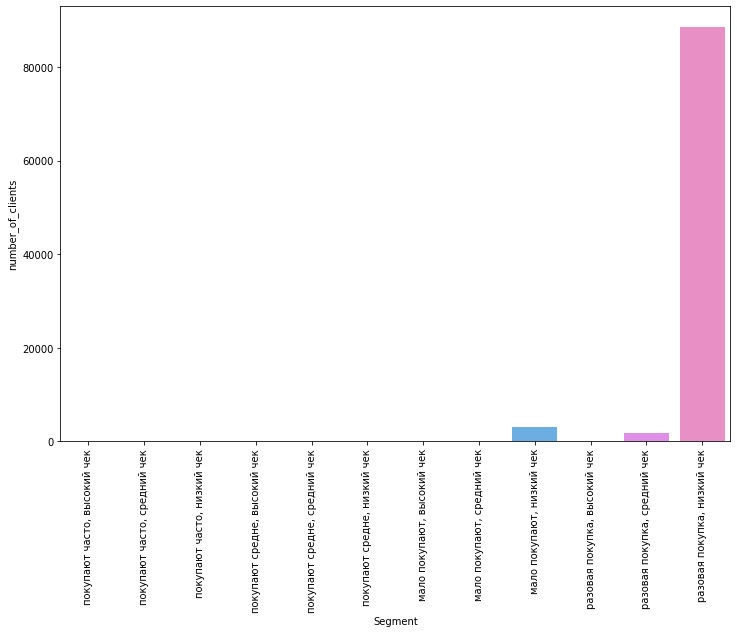

In [85]:
#строим графики
sns.barplot(x='Segment', y='number_of_clients', data=for_grafic) 
plt.rcParams['figure.figsize'] = (12, 8)
plt.xticks(rotation=90)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa9ade1cb38>]],
      dtype=object)

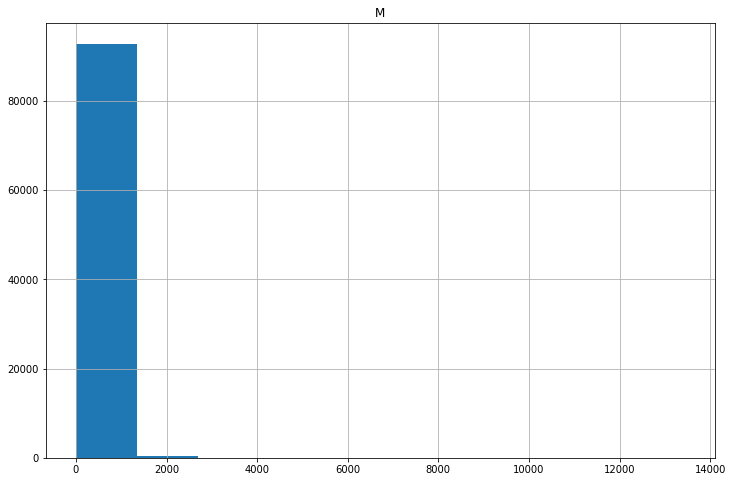

In [86]:
RFM.groupby('customer_unique_id').agg({'M':'sum'}).hist()

In [87]:
RFM.M.describe()

count    93345.000000
mean       137.419858
std        210.452572
min          0.850000
25%         45.900000
50%         86.900000
75%        149.900000
max      13440.000000
Name: M, dtype: float64

In [88]:
RFM.M.mode()

0    59.9
dtype: float64

(array([0, 1, 2, 3]), <a list of 4 Text major ticklabel objects>)

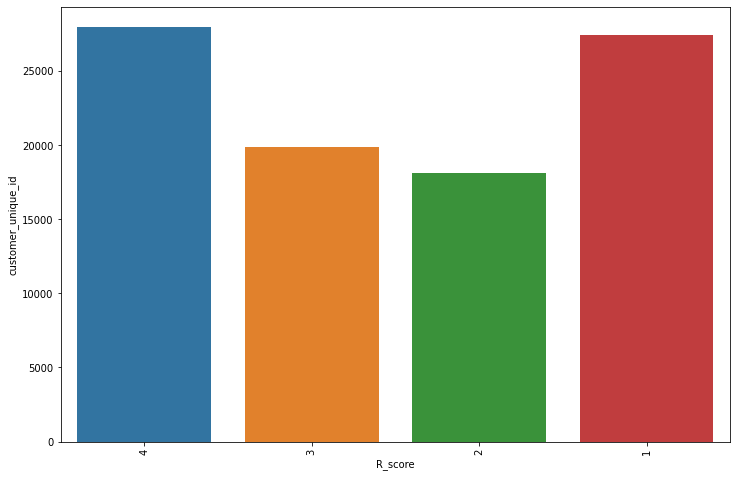

In [89]:
R = RFM.groupby('R_score', as_index = False).agg({'customer_unique_id':'count'})
#строим графики
sns.barplot(x='R_score', y='customer_unique_id', data=R) 
plt.rcParams['figure.figsize'] = (12, 8)
plt.xticks(rotation=90)

Исходя из результатов, полученных после анализа представленных данных, можно сделать вывод, что, хоть общее число покупателей и растет со временем, подавляющее число пользователей делают покупки единоразово. Повторные покупки совершают около 3% пользователей,  на крайне низкую 'возвращаемость' указывает также показатель Retention. 

Большинство пользователей делают покупки на сумму менее 100 долларов (наиболее частая сумма покупки - 59.9 долл., медианный чек - 86,9 долл., средний чек 137,4 долл).

Стоит провести опрос клиентов, взаимодействовавших с магазином, чтобы разработать стратегию, по повышению уровня лояльности, выяснить причину, почему покупатели не возвращаются (возможно наладить логистику, т.к. было зафиксировано, что с ней не все в порядке и около 40% заказов в месяц имеют статус недоступен или отменен).
Либо единичные покупки могут обьясняться спецификой продаваемого товара, и, в таком случае, стоит разработать рекламную компанию, которая могла бы повысить спрос на товары более высокого класса и цены (хотя, учитывая разброс цен на товары и существующую 'сезонность' по дням недели, скорее всего, магазин продает широкий ассортимент разнообразных товаров).  